In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import glob
import quadpy
from matplotlib.offsetbox import AnchoredText
import getdist
from getdist import plots, MCSamples
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
pantheon_ori_fits=pd.read_csv("pantheon_original_fit.txt",sep="\s+")

## Carregando dados EXP

In [3]:
glob.glob("./lc_fit_results*.txt")

['./lc_fit_results_EXP_FA_VARIMAX_SNLS_Pantheon.txt',
 './lc_fit_results_EXP_FA_VARIMAX_LOWZ_Pantheon.txt',
 './lc_fit_results_EXP_FA_VARIMAX_PS1_Pantheon.txt',
 './lc_fit_results_EXP_FA_VARIMAX_SDSS_Pantheon.txt',
 './lc_fit_results_EXP_FA_VARIMAX_HST_Pantheon.txt']

In [4]:
SDSS_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_SNLS_Pantheon.txt",sep="\s+")
PS1_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_PS1_Pantheon.txt",sep="\s+")
HST_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_HST_Pantheon.txt",sep="\s+")
LOWZ_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_LOWZ_Pantheon.txt",sep="\s+")

In [5]:
df_exp_bf_cuts=pd.concat([PS1_fits,SNLS_fits,SDSS_fits,LOWZ_fits,HST_fits])

In [6]:
df_exp=df_exp_bf_cuts[(df_exp_bf_cuts["X1"]>-0.5) & (df_exp_bf_cuts["X1"]<0.2) &
                      (df_exp_bf_cuts["X2/C"]>-0.2) & (df_exp_bf_cuts["X2/C"]<0.4) &
                      (df_exp_bf_cuts["X1ERR"]>0.) & (df_exp_bf_cuts["X1ERR"]<1.) &
                      (df_exp_bf_cuts["X2/CERR"]>0.) & (df_exp_bf_cuts["X2/CERR"]<1.) &
                      (df_exp_bf_cuts["CHISQ/NDOF"]<=15.)].reset_index(drop=True)

## Carregando dados SALT2

In [7]:
glob.glob("./fits_SALT2/lc_fit_results*.txt")

['./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt']

In [8]:
SDSS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt",sep="\s+")
PS1_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt",sep="\s+")
HST_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt",sep="\s+")
LOWZ_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt",sep="\s+")

In [9]:
df_salt2_bf_cuts=pd.concat([PS1_fits_SALT2,SNLS_fits_SALT2,SDSS_fits_SALT2,LOWZ_fits_SALT2,HST_fits_SALT2])

In [10]:
df_salt2=df_salt2_bf_cuts[(abs(df_salt2_bf_cuts["X1"])<=3.) & (abs(df_salt2_bf_cuts["X2/C"])<=0.3)].reset_index(drop=True)

## MCMC

#### MCMC EXP

In [11]:
class cosmo:
    def __init__(self, data):
        self.data = data
        
    def dL(self,Ok, integral):
        if(Ok[0]>0.):
            return 1./np.sqrt(Ok[0])*np.sinh(np.sqrt(Ok[0])*np.array(integral))
        elif(Ok[0]==0.):
            return integral
        elif(Ok[0]<0.):
            return 1./np.sqrt(-Ok[0])*np.sin(np.sqrt(-Ok[0])*np.array(integral))
    
    def log_likelihood_exp(self,theta):
        alpha, beta, sigma=theta
        Om=0.2906
        Ol=0.4125
        M=15.8393
        deltaM=-0.0378

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]-2.5*np.log10(1-self.data["x1"]*alpha+self.data["x2"]*beta)-deltaM*self.data["is_log_mass_g_10"]
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        fator=-2.5/(np.log(10.)*(1-self.data["x1"]*alpha+self.data["x2"]*beta))
        
        cov=-2.*fator*alpha*self.data["cov_mB_x1"]+2.*fator*beta*self.data["cov_mB_x2"]-2.*fator**2*alpha*beta*self.data["cov_x1_x2"]
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+fator**2*alpha**2.*self.data["x1err"]**2+fator**2*beta**2.*self.data["x2err"]**2.+cov
        
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_prior_exp(self, theta):
        alpha, beta, sigma=theta     
        if not (-1. < alpha < 6. and -1.< beta < 6. and 0.< sigma <0.5):
            return -np.inf
        return 0. 
        
    def log_probability_exp(self,theta):
        lp = self.log_prior_exp(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood_exp(theta)


In [12]:
exp_data=df_exp[df_exp["SNNAME"].isin(df_salt2["SNNAME"])].reset_index(drop=True)

In [13]:
exp_data["SNNAME"]=exp_data["SNNAME"].astype("str")

In [14]:
hostmass={}

In [15]:
i=0
j=0
for sn in pantheon_ori_fits["CID"]:
    if sn in exp_data["SNNAME"].values:
        i+=1
        hostmass[sn]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
        continue
    else:
        try:
            sn_int=int(sn)
            if str(sn_int) in exp_data["SNNAME"].values:
                i+=1
                hostmass[str(sn_int)]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
                continue
            else:
                j+=1
                continue
        except:
            j+=1
            continue

print(f"{j} não estão na lista")
print(f"{i} estão na lista")

254 não estão na lista
794 estão na lista


In [16]:
reduced_exp_data=exp_data[exp_data["SNNAME"].isin(hostmass.keys())].reset_index(drop=True)

In [17]:
col_hostmass=[]
is_log_mass_g_10=[]
for sn in reduced_exp_data["SNNAME"]:
    col_hostmass.append(hostmass[sn])
    if hostmass[sn]<10.:
        is_log_mass_g_10.append(0.)
    else:
        is_log_mass_g_10.append(1.)

In [18]:
col_hostmass=pd.DataFrame(col_hostmass)
col_hostmass.columns=["LOG_HOST_GAL_MASS"]
is_log_mass_g_10=pd.DataFrame(is_log_mass_g_10)
is_log_mass_g_10.columns=["is_log_mass_g_10"]

In [19]:
final_exp_data=pd.concat((reduced_exp_data,col_hostmass,is_log_mass_g_10),axis=1)

In [20]:
data_exp=final_exp_data[["SNNAME","LOG_HOST_GAL_MASS","Z","ZERR","mB","mBERR","X1","X1ERR","X2/C","X2/CERR","COV_mB_X1","COV_mB_X2/C","COV_X1_X2/C","is_log_mass_g_10"]]

In [21]:
data_exp.columns=["sn","log_hm","z","zerr","mB","mBerr","x1","x1err","x2","x2err","cov_mB_x1","cov_mB_x2","cov_x1_x2","is_log_mass_g_10"]

In [22]:
len(data_exp)

794

In [23]:
data_z_sorted=data_exp.sort_values("z").reset_index(drop=True)

In [24]:
intervalo1=data_z_sorted[data_z_sorted["z"]<0.024] # 49 sn
intervalo2=data_z_sorted[(data_z_sorted["z"]>=0.024) & (data_z_sorted["z"]<0.035)] # 51 sn
intervalo3=data_z_sorted[(data_z_sorted["z"]>=0.035) & (data_z_sorted["z"]<0.058)] # 43 sn
intervalo4=data_z_sorted[(data_z_sorted["z"]>=0.058) & (data_z_sorted["z"]<0.11)] # 45 sn
intervalo5=data_z_sorted[(data_z_sorted["z"]>=0.11) & (data_z_sorted["z"]<0.14)] # 42 sn
intervalo6=data_z_sorted[(data_z_sorted["z"]>=0.14) & (data_z_sorted["z"]<0.17)] # 39 sn
intervalo7=data_z_sorted[(data_z_sorted["z"]>=0.17) & (data_z_sorted["z"]<0.19)] # 44 sn
intervalo8=data_z_sorted[(data_z_sorted["z"]>=0.19) & (data_z_sorted["z"]<0.215)] # 43 sn
intervalo9=data_z_sorted[(data_z_sorted["z"]>=0.215) & (data_z_sorted["z"]<0.246)] # 45 sn
intervalo10=data_z_sorted[(data_z_sorted["z"]>=0.246) & (data_z_sorted["z"]<0.27)] # 47 sn
intervalo11=data_z_sorted[(data_z_sorted["z"]>=0.27) & (data_z_sorted["z"]<0.3)] # 42 sn
intervalo12=data_z_sorted[(data_z_sorted["z"]>=0.3) & (data_z_sorted["z"]<0.335)] # 43 sn
intervalo13=data_z_sorted[(data_z_sorted["z"]>=0.335) & (data_z_sorted["z"]<0.375)] # 43 sn
intervalo14=data_z_sorted[(data_z_sorted["z"]>=0.375) & (data_z_sorted["z"]<0.45)] # 41 sn
intervalo15=data_z_sorted[(data_z_sorted["z"]>=0.45) & (data_z_sorted["z"]<0.55)] # 42 sn
intervalo16=data_z_sorted[(data_z_sorted["z"]>=0.55) & (data_z_sorted["z"]<0.66)] # 47 sn
intervalo17=data_z_sorted[(data_z_sorted["z"]>=0.66) & (data_z_sorted["z"]<0.85)] # 44 sn
intervalo18=data_z_sorted[(data_z_sorted["z"]>=0.85) & (data_z_sorted["z"]<1.3)] # 36 sn

In [25]:
len(data_exp[data_exp["z"]>=1.3]) # 8 sn are not considered

8

In [26]:
for dat in [intervalo1,intervalo2,intervalo3,intervalo4,intervalo5,intervalo6,intervalo7,intervalo8,intervalo9,intervalo10,intervalo11,intervalo12,intervalo13,intervalo14,intervalo15,intervalo16,intervalo17,intervalo18]:
    print(np.mean(dat["z"]))

0.01725671293371204
0.029638071875199994
0.045190399517381394
0.08668939944370001
0.12697050000000001
0.1532592307692308
0.18017504545454543
0.2036151860465117
0.23034628888888878
0.25590036170212765
0.2846988095238095
0.3169796976744187
0.3552084186046511
0.4133853658536586
0.4964214285714287
0.5954957446808513
0.7441477272727272
0.9451444444444442


-85.33379304787326


100%|███████████████████████████████████████| 5000/5000 [04:21<00:00, 19.11it/s]


40.77357135922574
0.64446


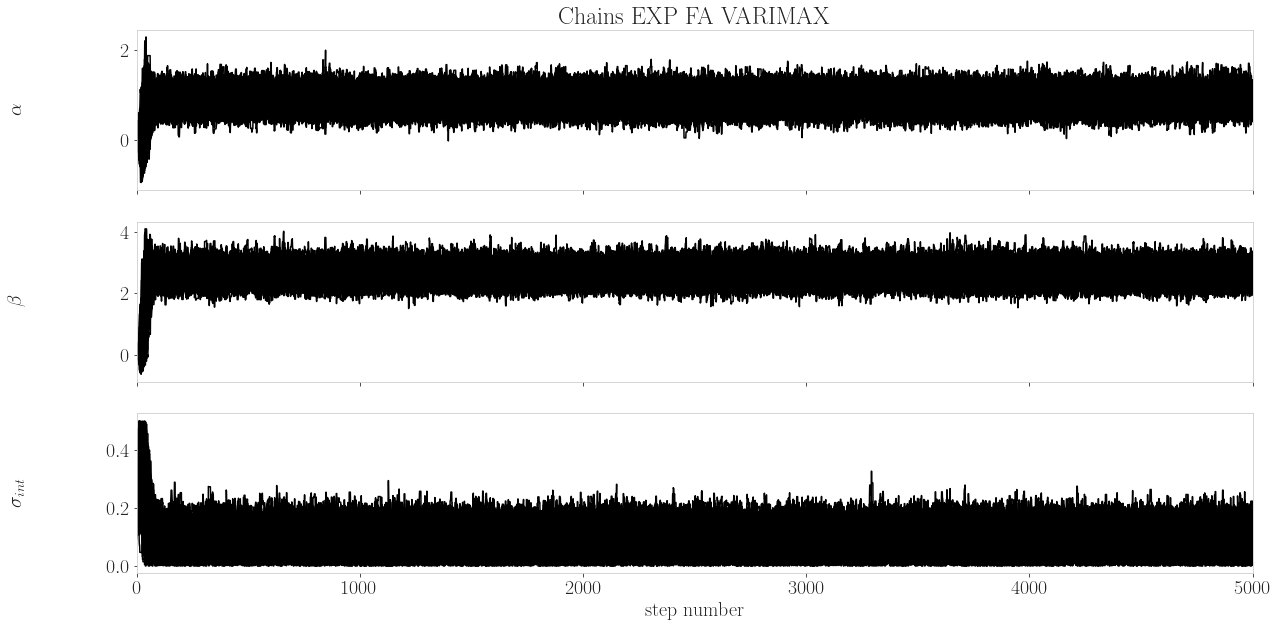

-134.643367010432


100%|███████████████████████████████████████| 5000/5000 [04:42<00:00, 17.73it/s]


39.799131992519456
0.6438119999999999


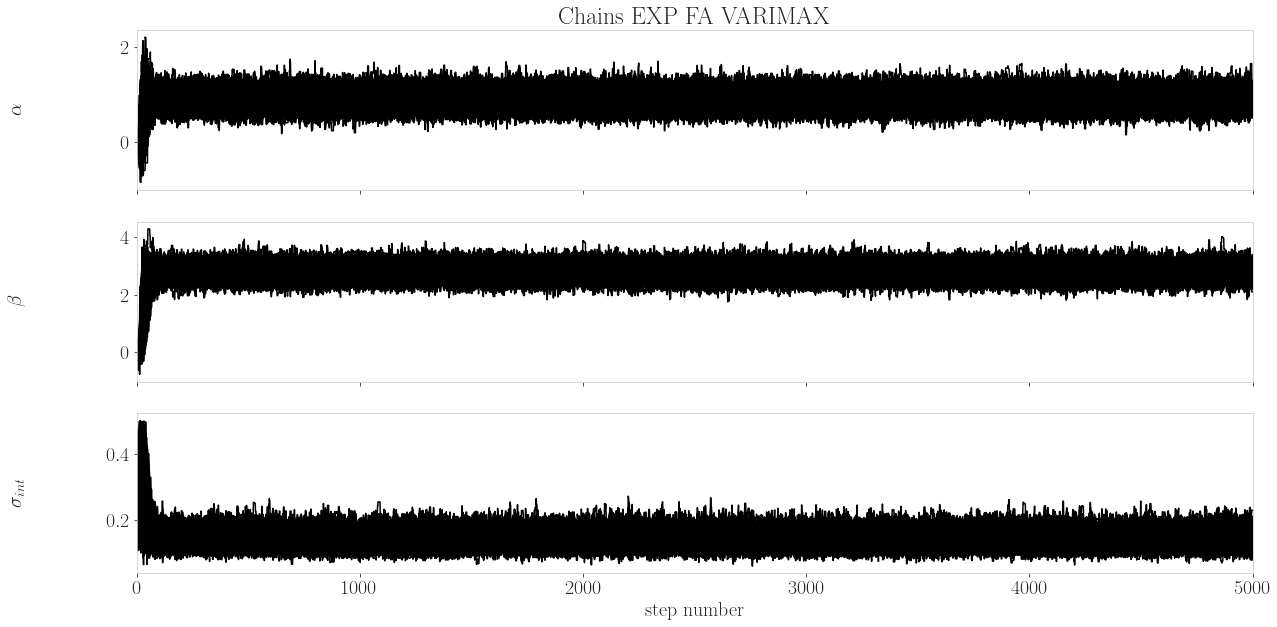

-103.32218739602085


100%|███████████████████████████████████████| 5000/5000 [04:43<00:00, 17.64it/s]


42.089829104351615
0.6436310000000001


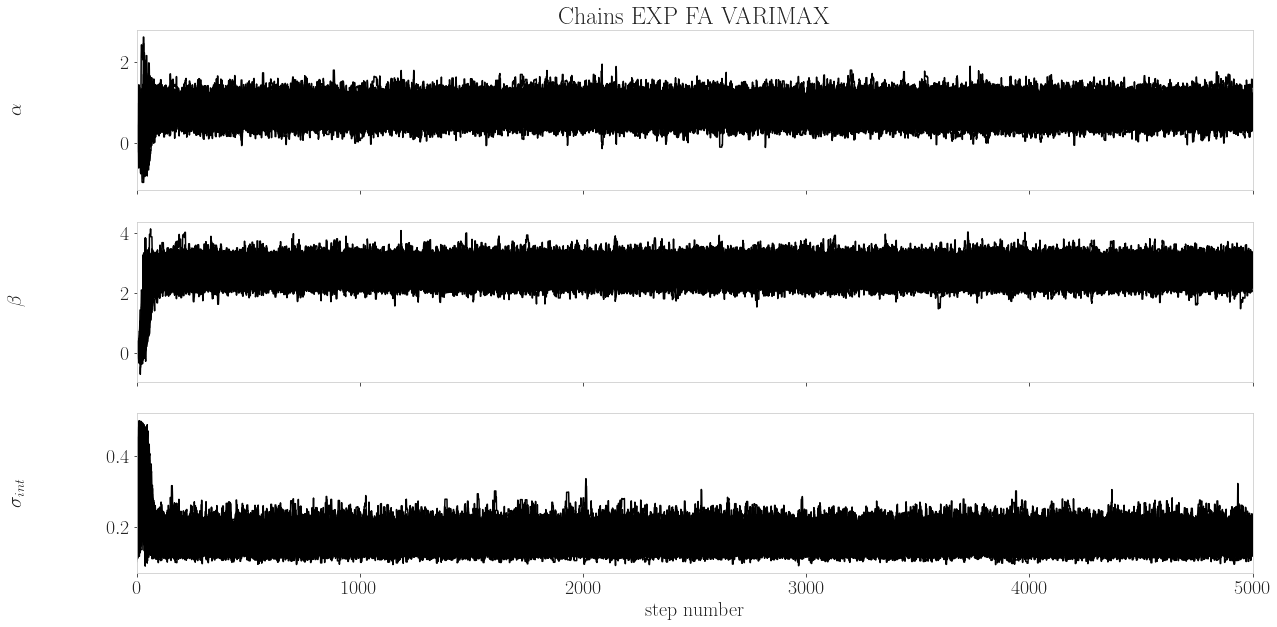

-153.43781345265307


100%|███████████████████████████████████████| 5000/5000 [04:43<00:00, 17.64it/s]


44.048496583046926
0.642164


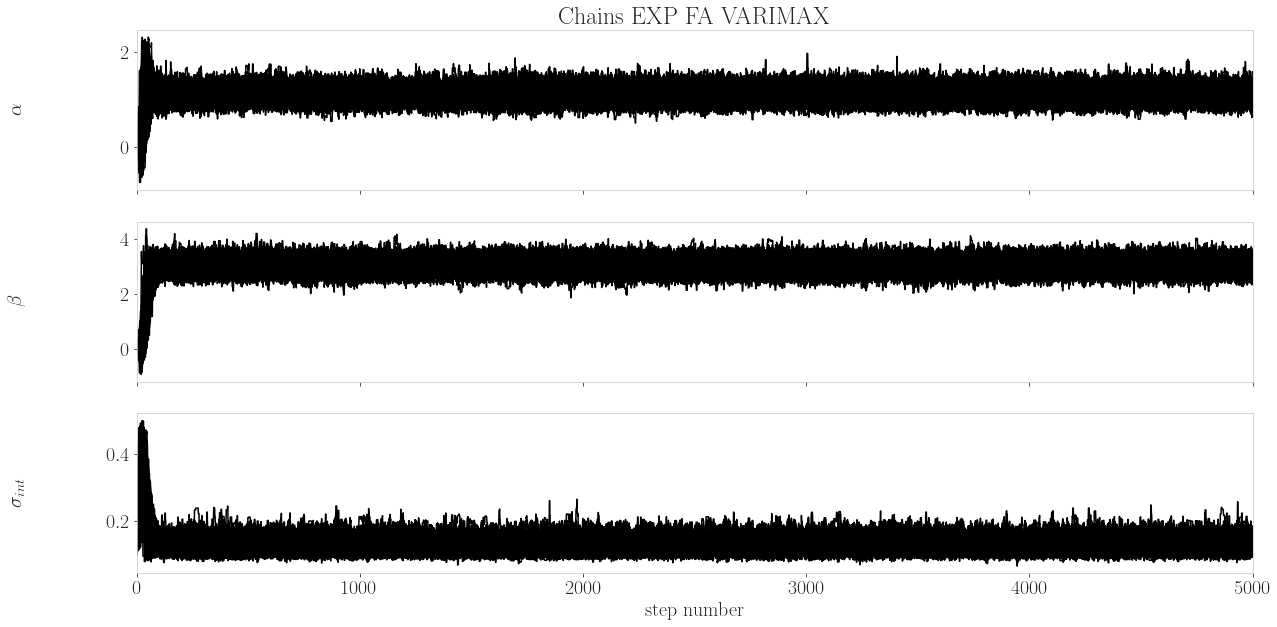

-140.18506383590002


100%|███████████████████████████████████████| 5000/5000 [04:46<00:00, 17.44it/s]


43.61351624163492
0.6426519999999999


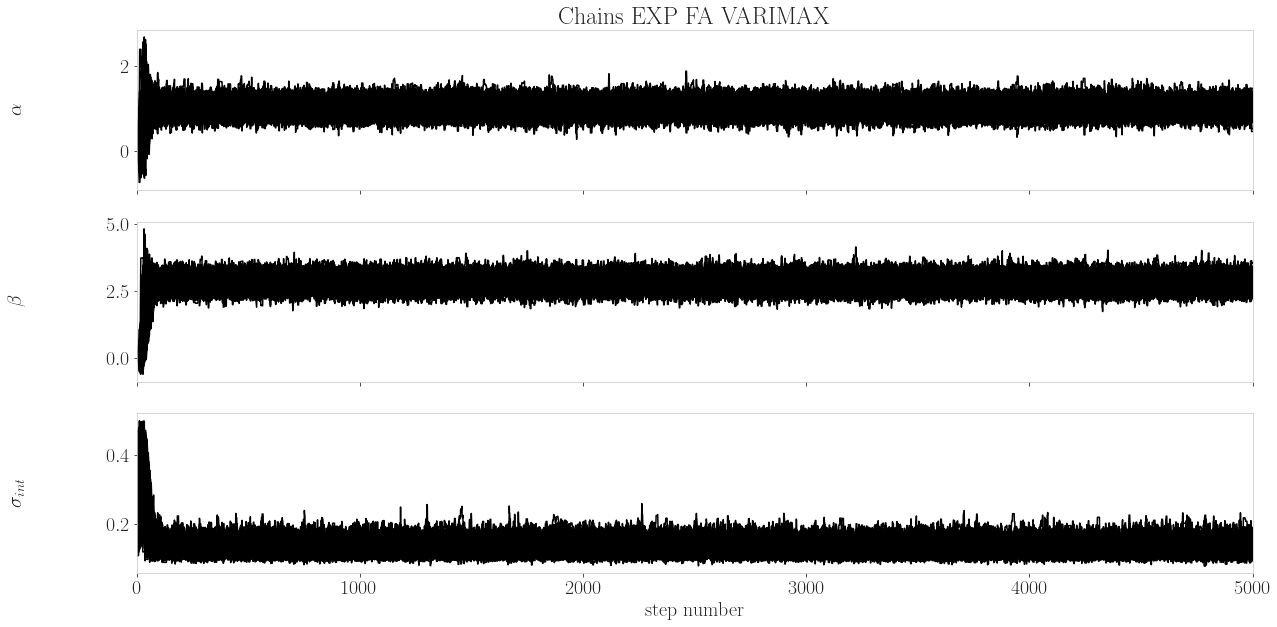

-71.63559282927454


100%|███████████████████████████████████████| 5000/5000 [04:50<00:00, 17.18it/s]


39.35947797500169
0.6433080000000001


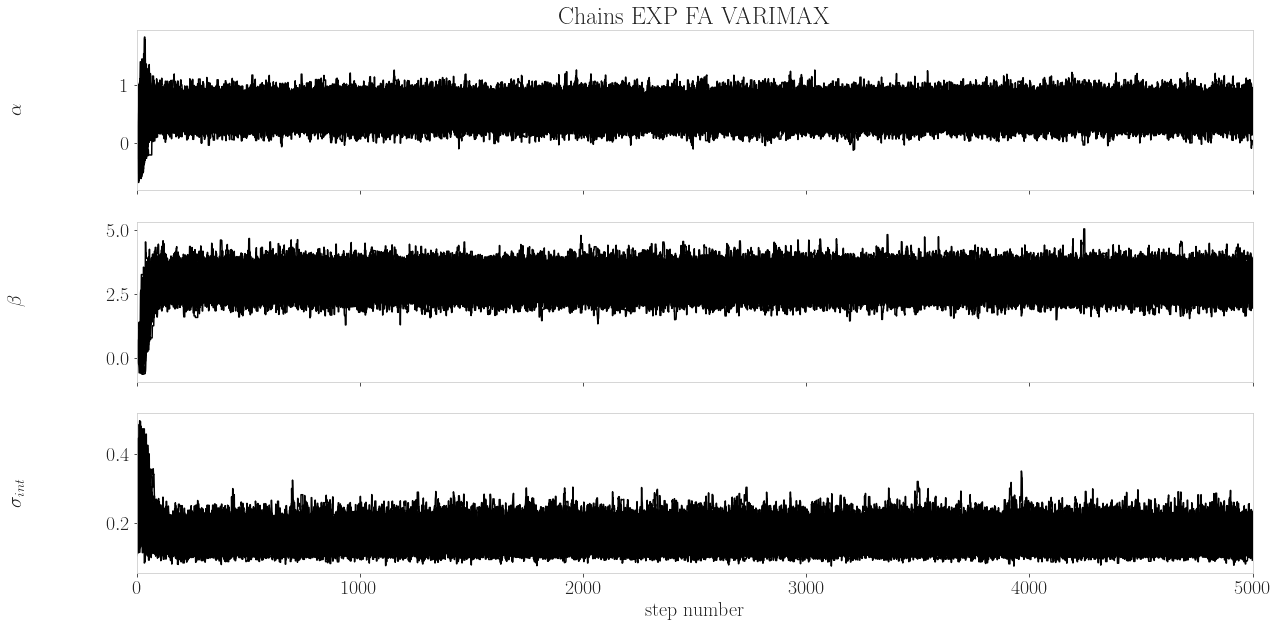

-41.671837192202005


100%|███████████████████████████████████████| 5000/5000 [04:46<00:00, 17.45it/s]


39.65539543460806
0.6452899999999999


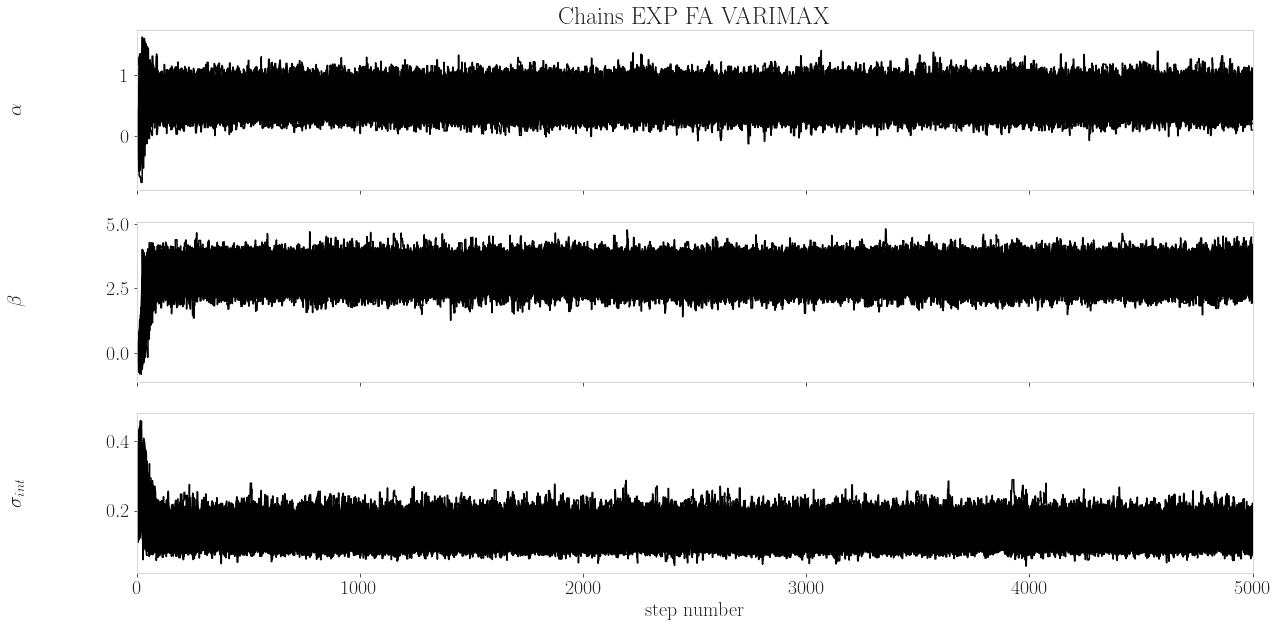

-19.959980888059658


100%|███████████████████████████████████████| 5000/5000 [04:47<00:00, 17.38it/s]


40.81004097070529
0.6451990000000001


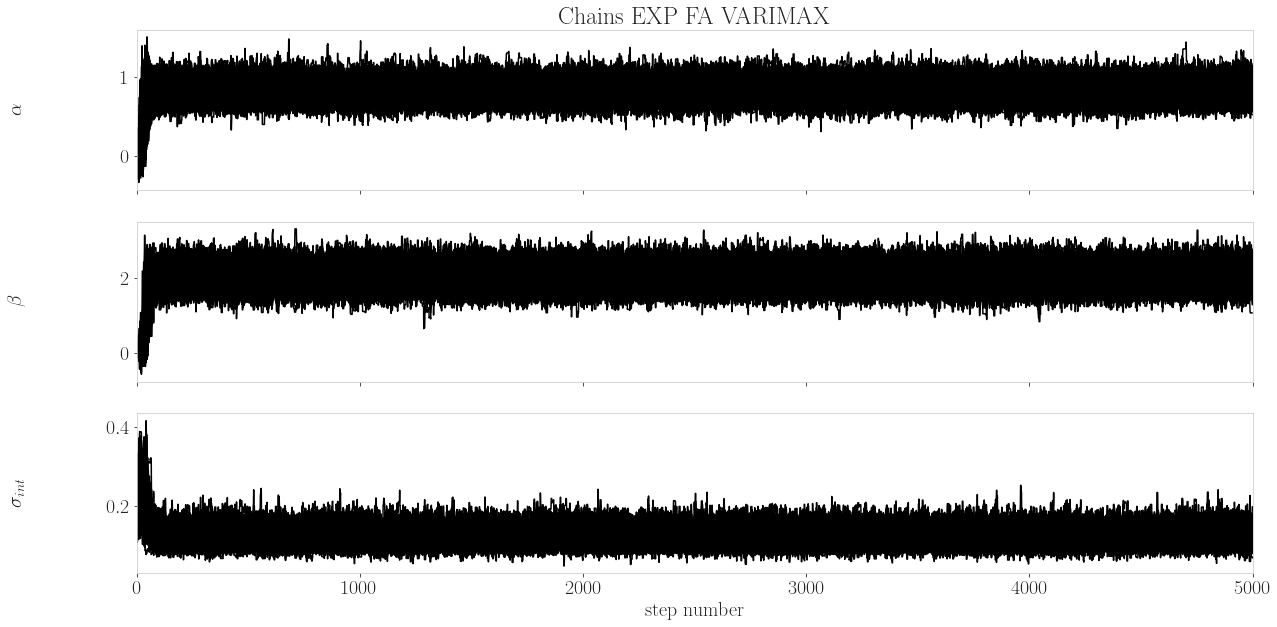

-82.51744421201595


100%|███████████████████████████████████████| 5000/5000 [04:49<00:00, 17.29it/s]


40.38957452674413
0.644453


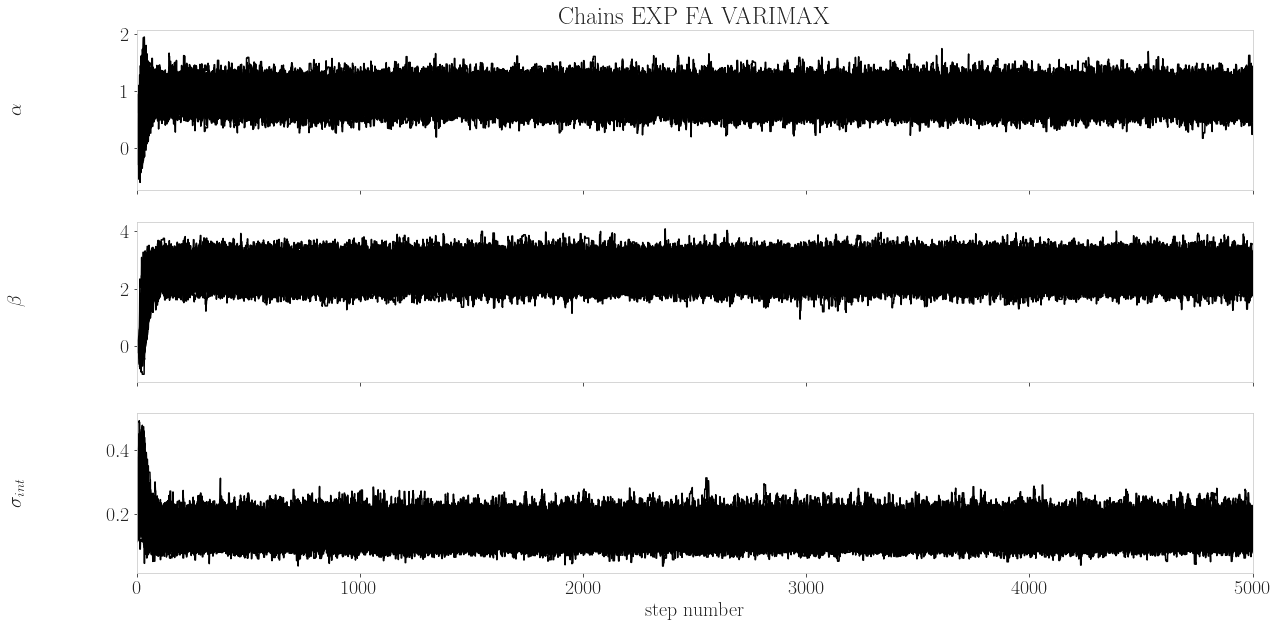

-37.99857381506164


100%|███████████████████████████████████████| 5000/5000 [04:49<00:00, 17.28it/s]


39.513996140278046
0.645618


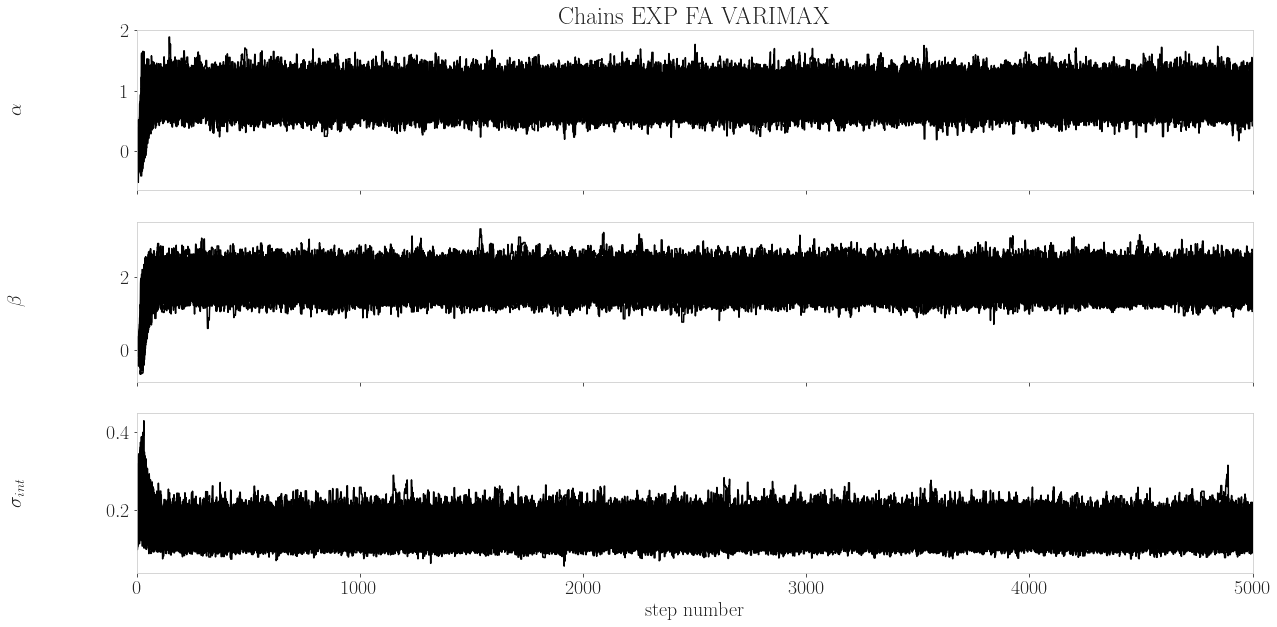

-37.8104506021619


100%|███████████████████████████████████████| 5000/5000 [04:47<00:00, 17.40it/s]


39.189801408733935
0.643579


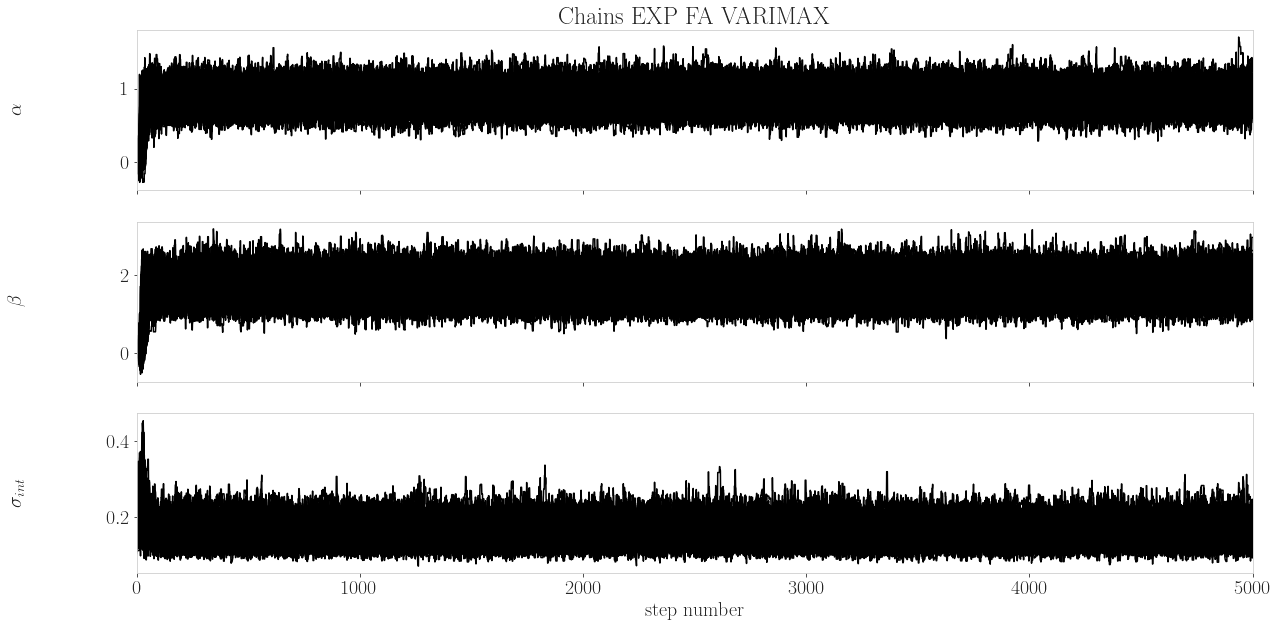

-53.84606642678133


 35%|█████████████▋                         | 1756/5000 [01:42<03:06, 17.43it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 35%|█████████████▊                         | 1774/5000 [01:43<03:06, 17.25it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 44%|█████████████████▎                     | 2220/5000 [02:09<02:35, 17.88it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|███████████████████████████████████████| 5000/5000 [04:46<00:00, 17.45it/s]


39.030861688702565
0.6421530000000001


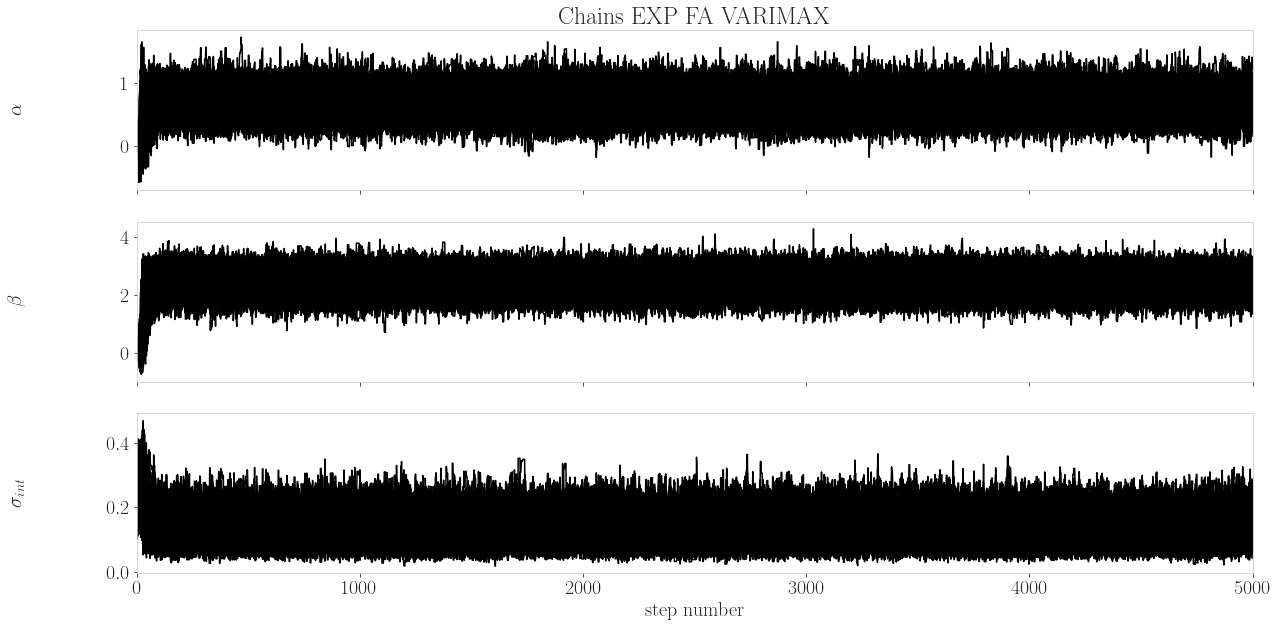

-78.23102754418923


100%|███████████████████████████████████████| 5000/5000 [04:47<00:00, 17.40it/s]


39.50229334368197
0.642895


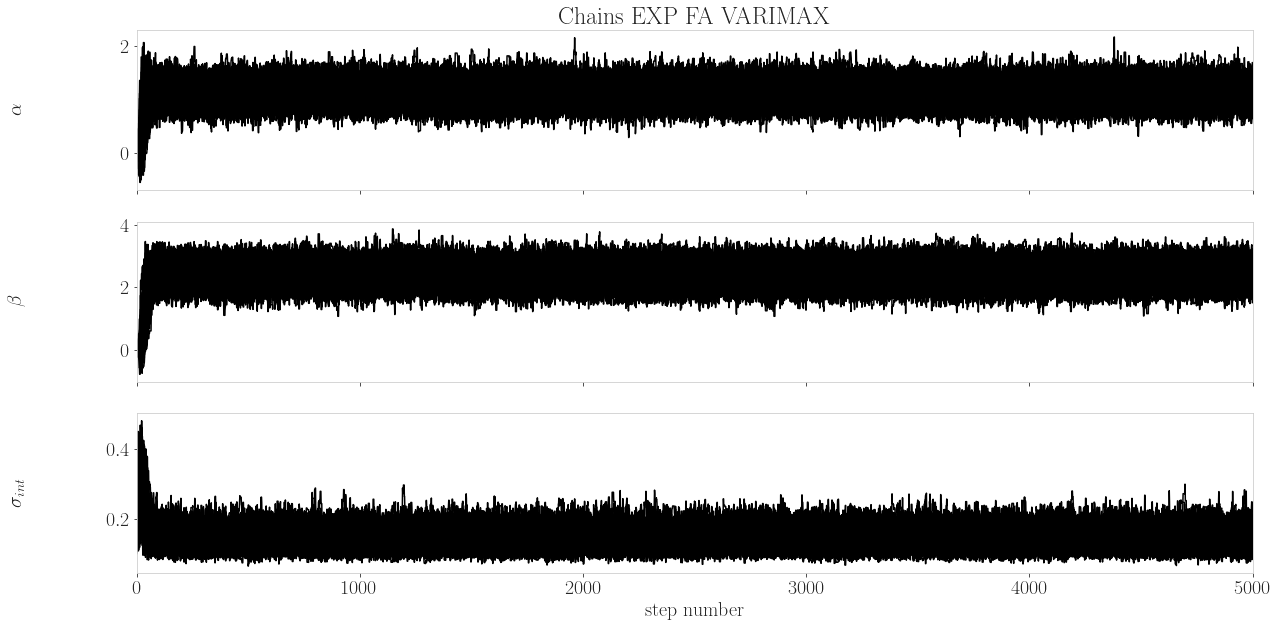

-29.698933940558838


100%|███████████████████████████████████████| 5000/5000 [04:49<00:00, 17.29it/s]


40.069006582654225
0.642035


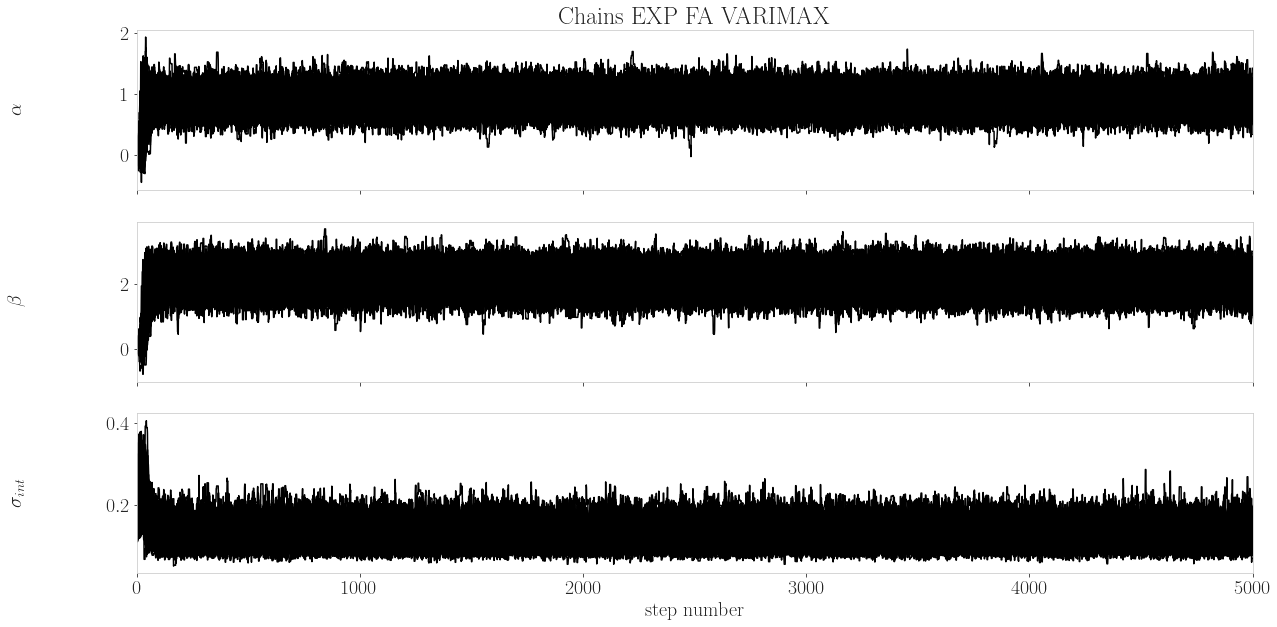

-39.623990880647995


100%|███████████████████████████████████████| 5000/5000 [04:48<00:00, 17.32it/s]


39.65420279254325
0.642855


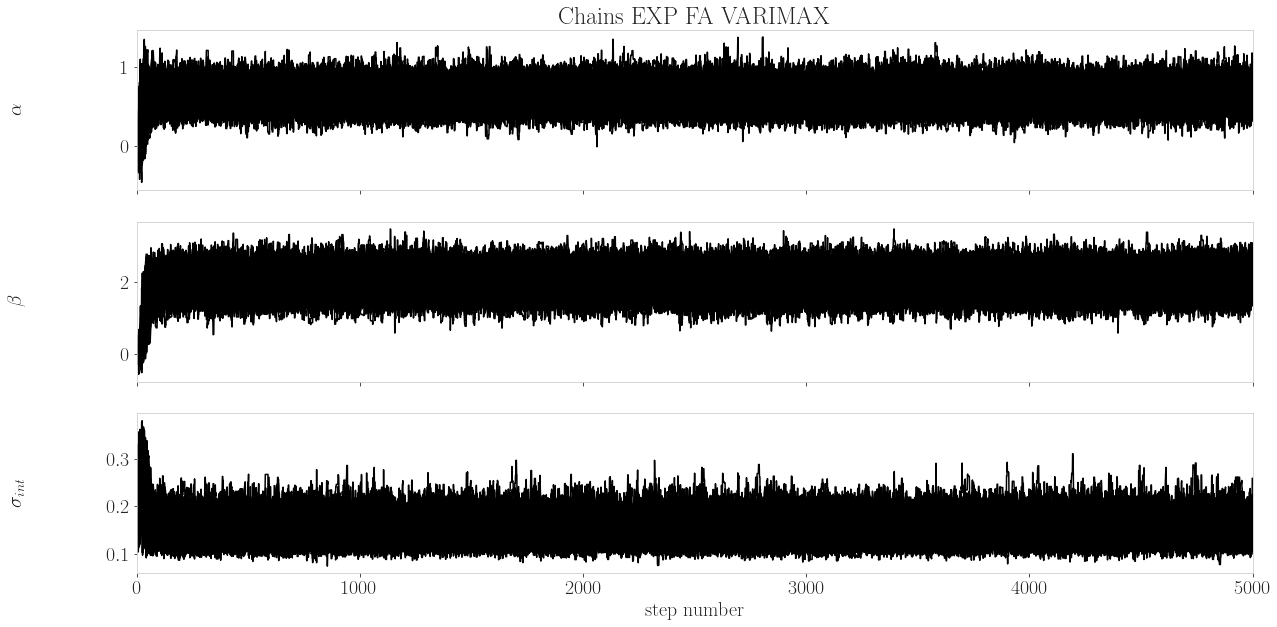

-124.70063139444287


100%|███████████████████████████████████████| 5000/5000 [04:46<00:00, 17.43it/s]


41.64899406798606
0.642404


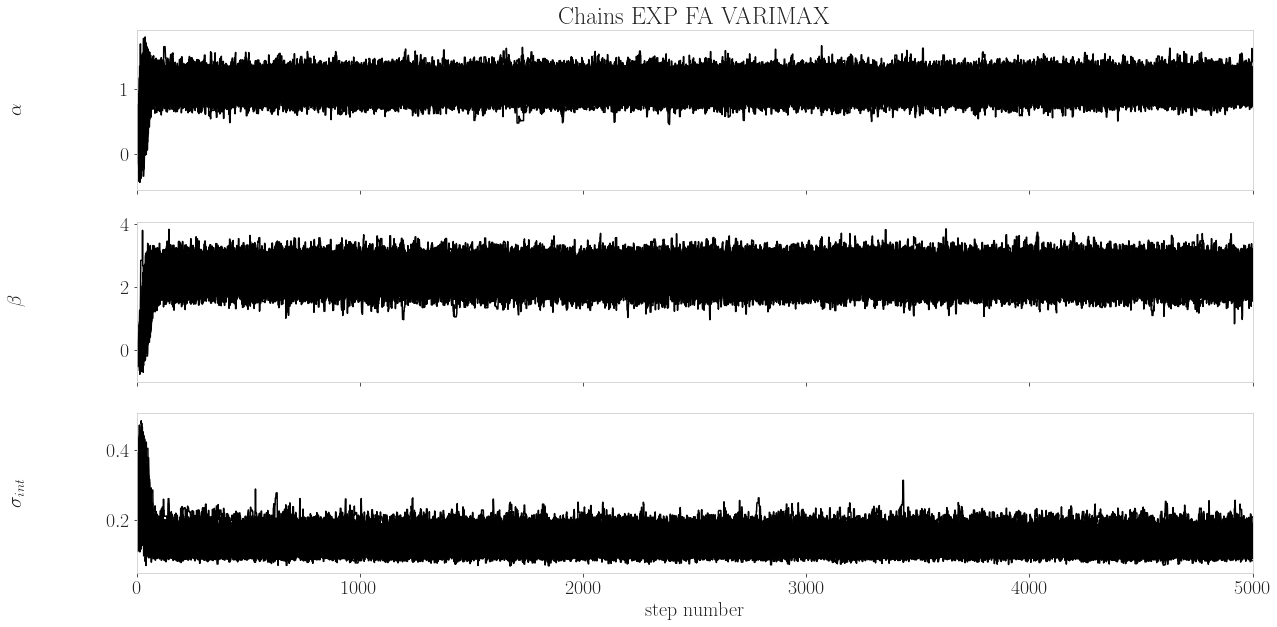

-28.30309017088995


100%|███████████████████████████████████████| 5000/5000 [04:46<00:00, 17.45it/s]


36.85436178662846
0.6472630000000001


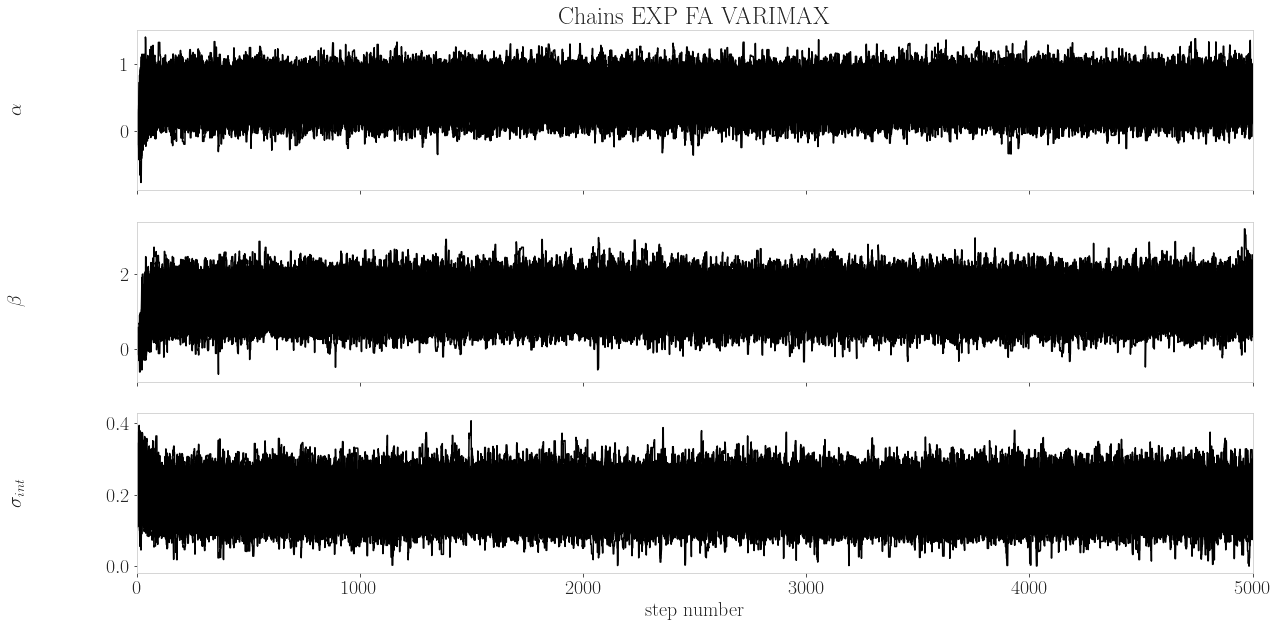

-14.85053276871094


100%|███████████████████████████████████████| 5000/5000 [04:48<00:00, 17.35it/s]


35.663919787362886
0.6467050000000001


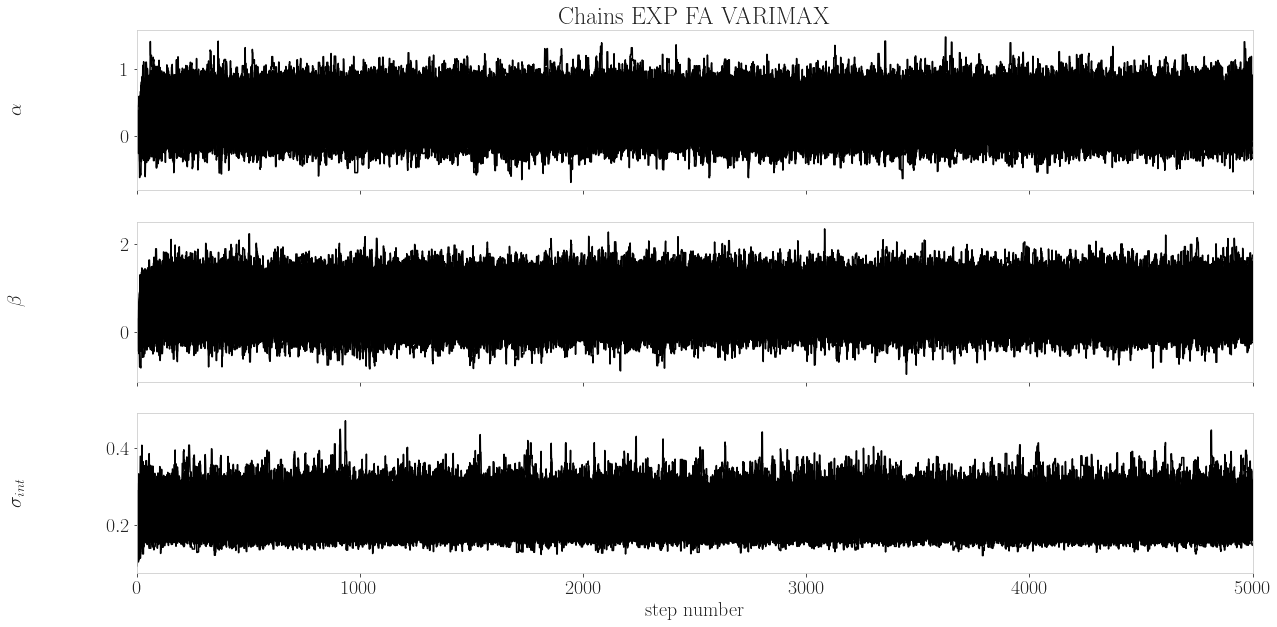

In [27]:
for j,dat in enumerate([intervalo1,intervalo2,intervalo3,intervalo4,intervalo5,intervalo6,intervalo7,intervalo8,intervalo9,intervalo10,intervalo11,intervalo12,intervalo13,intervalo14,intervalo15,intervalo16,intervalo17,intervalo18]):
    cosmo_exp=cosmo(dat)
    print(cosmo_exp.log_probability_exp([0.08,0.08,0.13]))
    pos = np.array([0.08,0.08,0.13])+0.01 *np.random.randn(200, 3)
    nwalkers, ndim = pos.shape
    
    with Pool() as pool:
        sampler_exp = emcee.EnsembleSampler(nwalkers, ndim, cosmo_exp.log_probability_exp, pool=pool)
        sampler_exp.run_mcmc(pos, 5000, progress=True)
    
    print(np.mean(sampler_exp.get_autocorr_time()))
    
    print(np.mean(sampler_exp.acceptance_fraction))
    
    fig, axes = plt.subplots(ndim, figsize=(20, 10), sharex=True)
    samples_exp = sampler_exp.get_chain()
    labels = [r"$\alpha$",r"$\beta$",r"$\sigma_{int}$"]

    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples_exp[:, :, i], "k")
        ax.set_xlim(0, len(samples_exp))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.grid(False)
        if i==0:
            ax.set_title("Chains EXP FA VARIMAX")

    
    axes[-1].set_xlabel("step number");
    
    plt.show()
    
    flat_samples_exp = sampler_exp.get_chain(discard=500, thin=10, flat=True)
    
    np.savetxt("./chains_evol_w_z_FA_varimax/chain_int"+str(j)+"_FA_varimax.txt",flat_samples_exp)